## Creacion de modelos

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report

In [150]:
data = pd.read_csv('credit_risk_dataset.csv')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [152]:
data = data.drop(index=data.query('person_emp_length > 100').index)

In [154]:
X_cat = data.drop(columns=['loan_status','cb_person_default_on_file',
                           'person_home_ownership']).select_dtypes(include=['object'])

X_num = data.drop(columns='loan_status').select_dtypes(include=['float','int'])
y = data.loan_status.to_numpy().flatten()

X = X_num.join(X_cat)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

In [156]:
X_train,X_val, y_train, y_val = train_test_split(X_train,y_train,stratify=y_train, train_size=0.70)

In [157]:
col_trans = ColumnTransformer([("cat_preprocess", TargetEncoder(), ["loan_grade"]),
                                ("cat_preprocess_2", TargetEncoder(), ["loan_intent"])],
                                remainder='passthrough').set_output(transform='pandas')

col_trans.fit_transform(X_train,y_train)


,cat_preprocess__loan_grade,cat_preprocess_2__loan_intent,remainder__person_age,remainder__person_income,remainder__person_emp_length,remainder__loan_amnt,remainder__loan_int_rate,remainder__loan_percent_income,remainder__cb_person_cred_hist_length
30162,0.100592,0.287633,39,48000,NaN,3000,5.42,0.06,11
2823,0.159003,0.287633,22,34900,6.0,4000,9.99,0.11,2
6907,0.159756,0.265573,23,80607,2.0,6000,12.21,0.07,2
22923,0.099790,0.258693,30,60000,3.0,21000,7.90,0.35,5
18548,0.097454,0.151697,31,24000,3.0,3000,7.49,0.13,10
...,...,...,...,...,...,...,...,...,...
31000,0.217958,0.143226,44,72061,8.0,4200,14.17,0.06,14
5672,0.158781,0.198508,25,106000,4.0,5000,NaN,0.05,4
12251,0.577661,0.198147,26,34000,2.0,12000,14.96,0.35,3
13464,0.217958,0.142190,26,14400,2.0,2500,13.47,0.17,4


In [158]:
new_intance = X_test.sample(1).reset_index(drop=True)

In [159]:
X_train = col_trans.transform(X_train)
X_val = col_trans.transform(X_val)
X_test = col_trans.transform(X_test)

### Tratamiento de datos inbalanceados

In [10]:
from sklearn.utils.class_weight import compute_class_weight
wc = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

### Gradient Boosting Model

In [160]:
#early stopping with xgboost classifier
xgb_clf = xgb.XGBClassifier(early_stopping_rounds=20)
xgb_clf.fit(X_train,y_train,
            eval_set=[(X_val, y_val)],
            verbose=5)

[0]	validation_0-logloss:0.41250
[5]	validation_0-logloss:0.29999
[10]	validation_0-logloss:0.28625
[15]	validation_0-logloss:0.27872
[20]	validation_0-logloss:0.27678
[25]	validation_0-logloss:0.27449
[30]	validation_0-logloss:0.27405
[35]	validation_0-logloss:0.27373
[40]	validation_0-logloss:0.27349
[45]	validation_0-logloss:0.27458
[50]	validation_0-logloss:0.27444
[55]	validation_0-logloss:0.27505
[57]	validation_0-logloss:0.27536


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
class_weights = {0: wc[0], 1: wc[1]}  # Ejemplo de pesos de clase

# Calcular sample_weight para cada muestra en el conjunto de entrenamiento
weight_array = np.array([class_weights[y] for y in y_train])

In [22]:
xgb_clf_cw = xgb.XGBClassifier(early_stopping_rounds=20)
xgb_clf_cw.fit(X_train,y_train,
            eval_set=[(X_val, y_val)],
            verbose=5,
            sample_weight = weight_array)

[0]	validation_0-logloss:0.56059
[5]	validation_0-logloss:0.38267
[10]	validation_0-logloss:0.35675
[15]	validation_0-logloss:0.34308
[20]	validation_0-logloss:0.33702
[25]	validation_0-logloss:0.33239
[30]	validation_0-logloss:0.32909
[35]	validation_0-logloss:0.32485
[40]	validation_0-logloss:0.32285
[45]	validation_0-logloss:0.32011
[50]	validation_0-logloss:0.31663
[55]	validation_0-logloss:0.31513
[60]	validation_0-logloss:0.31302
[65]	validation_0-logloss:0.31119
[70]	validation_0-logloss:0.31120
[75]	validation_0-logloss:0.31051
[80]	validation_0-logloss:0.30997
[85]	validation_0-logloss:0.30949
[90]	validation_0-logloss:0.30863
[95]	validation_0-logloss:0.30743
[99]	validation_0-logloss:0.30750


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [161]:
print('Classification Report of Unweighted Model')
print('='*100)
print(classification_report(y_test,xgb_clf.predict(X_test)))

Classification Report of Unweighted Model
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6368
           1       0.81      0.67      0.73      1777

    accuracy                           0.89      8145
   macro avg       0.86      0.81      0.83      8145
weighted avg       0.89      0.89      0.89      8145



In [31]:
print('Classification Report of Weighted Model')
print('='*100)
print(classification_report(y_test,xgb_clf_cw.predict(X_test)))

Classification Report of Weighted Model
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      6369
           1       0.71      0.79      0.75      1777

    accuracy                           0.88      8146
   macro avg       0.82      0.85      0.83      8146
weighted avg       0.89      0.88      0.88      8146



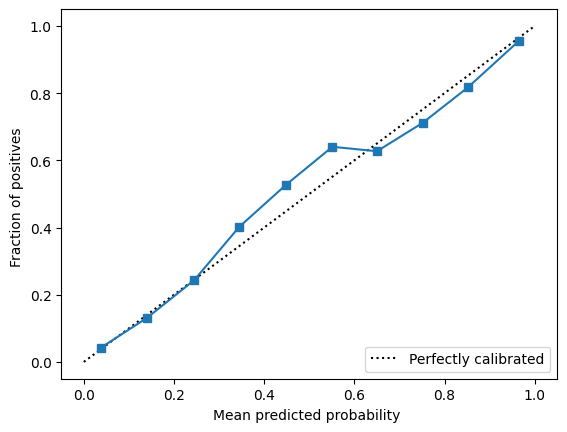

In [162]:
# Check the calibration curve
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_prob = xgb_clf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

### Optimizacion de hiperparametros

In [183]:
import optuna
from sklearn.metrics import log_loss

# 1. Define an objective function to be maximized.
def objective(trial):
    ...

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'eval_metric':'logloss'
    }

    bst = xgb.XGBClassifier(**param)
    bst.fit(X_train, y_train)
    
    metric = log_loss(y_val,
                      bst.predict_proba(X_val)[:, 1])


    return metric

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-09-02 10:30:39,249] A new study created in memory with name: no-name-931372a6-8620-46a6-b222-27b70611e81c
[I 2024-09-02 10:30:42,225] Trial 0 finished with value: 0.29142404626332236 and parameters: {'booster': 'dart', 'lambda': 0.0018514602900496703, 'alpha': 6.279584739467137e-07, 'subsample': 0.7649256140673244, 'colsample_bytree': 0.49420311547330154}. Best is trial 0 with value: 0.29142404626332236.
[I 2024-09-02 10:30:42,346] Trial 1 finished with value: 0.3054068382230507 and parameters: {'booster': 'gbtree', 'lambda': 4.6556175373342476e-07, 'alpha': 5.565277530894131e-07, 'subsample': 0.6015795209014507, 'colsample_bytree': 0.5738205240111275}. Best is trial 0 with value: 0.29142404626332236.
c:\Users\PC\OneDrive\Documentos\credit_portfolio\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsa

In [201]:
best_model = xgb.XGBClassifier(**study.best_params,
                               early_stopping_rounds=20).set_fit_request(eval_set=True)

best_model.fit(X_train,y_train,
            eval_set=[(X_val, y_val)],
            verbose=5)

[0]	validation_0-logloss:0.46633
[5]	validation_0-logloss:0.34590
[10]	validation_0-logloss:0.32571
[15]	validation_0-logloss:0.30592
[20]	validation_0-logloss:0.29450
[25]	validation_0-logloss:0.28807
[30]	validation_0-logloss:0.28431
[35]	validation_0-logloss:0.28383
[40]	validation_0-logloss:0.28077
[45]	validation_0-logloss:0.27929
[50]	validation_0-logloss:0.27710
[55]	validation_0-logloss:0.27759
[60]	validation_0-logloss:0.27858
[65]	validation_0-logloss:0.27738
[70]	validation_0-logloss:0.27774


XGBClassifier(alpha=8.989738506909321e-07, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3622106755002568, device=None,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.028052595131969085,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [186]:
print(classification_report(y_test, best_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6368
           1       0.81      0.66      0.73      1777

    accuracy                           0.89      8145
   macro avg       0.86      0.81      0.83      8145
weighted avg       0.89      0.89      0.89      8145



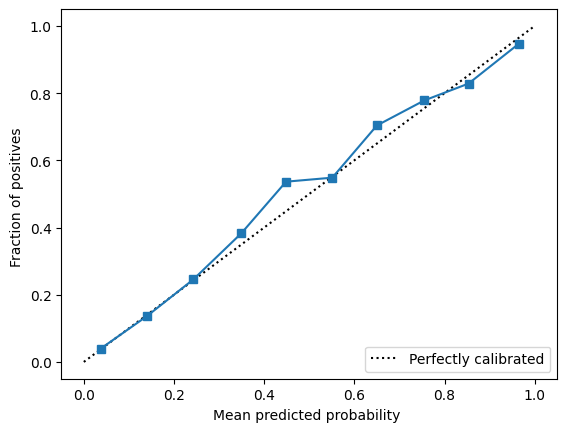

In [187]:
y_prob = best_model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

### Create Pipeline

In [202]:
from sklearn.pipeline import Pipeline

In [203]:
pipe = Pipeline([('transformer',col_trans),
                 ('xgb_model',best_model)])

### Model Performance Metrics

In [204]:
# Tabla de estrategia
pred_train = pd.DataFrame()
pred_train['prob_default'] = best_model.predict_proba(X_train)[:,1]
pred_train['true_status'] = y_train

pred_test = pd.DataFrame()
pred_test['prob_default'] = best_model.predict_proba(X_test)[:,1]
pred_test['true_status'] = y_test

pred_train['loan_amount'] = X_train.remainder__loan_amnt
pred_test['loan_amount'] = X_test.remainder__loan_amnt

In [206]:
def strat_table(df:pd.DataFrame) -> pd.DataFrame:

    accepted_rate = [i for i in np.arange(0.05,1.05,0.05)]
    threshold_array = []
    bad_rate = []
    num_accepted_loans = []

    for rate in accepted_rate:
        threshold = np.quantile(df.prob_default,rate).round(3)

        threshold_array.append(threshold)
        accepted_loans = df.query('prob_default <= @threshold')
        accepted_defaults = accepted_loans.query('true_status == 1')
        n_accepted = accepted_loans.shape[0]
        
        num_accepted_loans.append(n_accepted)
        br = accepted_defaults.shape[0]/accepted_loans.shape[0]
        bad_rate.append(br)

    strat_table = pd.DataFrame(zip(accepted_rate,threshold_array,bad_rate),
                                 columns=['Acceptance Rate','Threshold','Bad Rate'])

    strat_table['Num Accepted Loans'] = num_accepted_loans

    strat_table['Estimated Value'] =np.round((strat_table['Num Accepted Loans'] * (1-strat_table['Bad Rate']) * df.loan_amount.mean()) - \
                                        (strat_table['Num Accepted Loans'] * (strat_table['Bad Rate']) * df.loan_amount.mean()))
    
    return strat_table

In [207]:
strat_table(pred_train)

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Estimated Value
0,0.05,0.006,0.000000,831,7775303.0
1,0.10,0.011,0.000000,1708,15981008.0
2,0.15,0.016,0.000755,2650,24757463.0
3,0.20,0.020,0.001191,3358,31344482.0
4,0.25,0.025,0.001433,4187,39063646.0
5,0.30,0.032,0.002508,5184,48261146.0
6,0.35,0.038,0.003849,5975,55475055.0
7,0.40,0.046,0.004977,6832,63287784.0
8,0.45,0.056,0.007040,7670,70754321.0
9,0.50,0.067,0.008788,8534,78445414.0


In [208]:
strat_table(pred_test)

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Estimated Value
0,0.05,0.006,0.000000,380,3044825.0
1,0.10,0.011,0.004957,807,6402146.0
2,0.15,0.016,0.008914,1234,9711390.0
3,0.20,0.021,0.012151,1646,12868394.0
4,0.25,0.027,0.014057,2063,16065460.0
5,0.30,0.033,0.020358,2456,18877917.0
6,0.35,0.040,0.025766,2872,21826590.0
7,0.40,0.047,0.027616,3259,24671098.0
8,0.45,0.056,0.028657,3664,27675860.0
9,0.50,0.067,0.033611,4076,30464279.0


In [209]:
# Calculate Expected Loss
expected_loss_train = np.sum(pred_train.prob_default * pred_train.loan_amount.mean())
print('Expected Loss for training set')
print(f'${expected_loss_train:,.2f}')

Expected Loss for training set
$34,997,852.00


In [210]:
expected_loss_test = np.sum(pred_test.prob_default * pred_test.loan_amount.mean())
print('Expected Loss for testing set')
print(f'${expected_loss_test:,.2f}')

Expected Loss for testing set
$14,014,654.00


### Simulacion de perdidas en el portafolio

In [254]:
from scipy.stats import bernoulli
from typing import Union

In [258]:
def credit_loss_simulation(probabilities:np.array,
                           amount:Union[np.array, pd.Series],
                           var=0.95)-> tuple:
    
    simulations = bernoulli.rvs(p=probabilities[:, np.newaxis], size=(len(probabilities), 1000))
    cl_simulation = np.sum((simulations * amount.mean()), axis=0)
    simulated_expected_loss = np.mean(cl_simulation)
    simulated_unexpected_loss = np.quantile(cl_simulation,var)
    cvar = np.mean(cl_simulation[cl_simulation > simulated_unexpected_loss])

    return (cl_simulation,simulated_expected_loss,simulated_unexpected_loss,cvar)


In [259]:
cl_sim_train, sim_exp_loss_train, sim_unexp_loss_train, cvar_train = credit_loss_simulation(pred_train.prob_default.to_numpy(),
                                                                                                       pred_train.loan_amount)

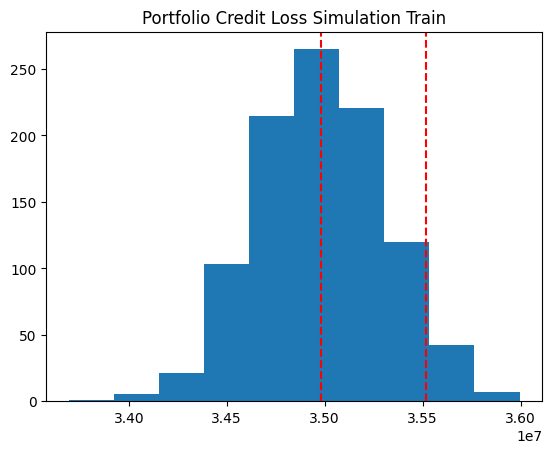

In [260]:
plt.hist(cl_sim_train)
plt.axvline(sim_exp_loss_train, ls='--', color='red')
plt.axvline(sim_unexp_loss_train, ls='--', color='red')
plt.title('Portfolio Credit Loss Simulation Train')
plt.show()

In [261]:
print('Simulated Expected Credit Loss')
print(f'{sim_exp_loss_train:,.2f}')
print('Simulated Unxpected Credit Loss -> VaR 99%')
print(f'{sim_unexp_loss_train:,.2f}')
print('Simulated Unxpected Credit Loss -> CVaR')
print(f'{cvar_train:,.2f}')

Simulated Expected Credit Loss
34,981,012.85
Simulated Unxpected Credit Loss -> VaR 99%
35,517,976.57
Simulated Unxpected Credit Loss -> CVaR
35,649,436.27


In [262]:
cl_sim_test, sim_exp_loss_test, sim_unexp_loss_test, cvar_test= credit_loss_simulation(pred_test.prob_default.to_numpy(),
                                                                                                       pred_test.loan_amount)

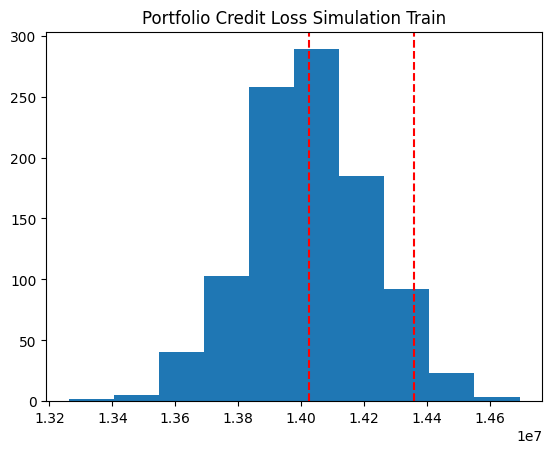

In [263]:
plt.hist(cl_sim_test)
plt.axvline(sim_exp_loss_test, ls='--', color='red')
plt.axvline(sim_unexp_loss_test, ls='--', color='red')
plt.title('Portfolio Credit Loss Simulation Train')
plt.show()

In [264]:
print('Simulated Expected Credit Loss')
print(f'{sim_exp_loss_test:,.2f}')
print('Simulated Unxpected Credit Loss -> VaR 99%')
print(f'{sim_unexp_loss_test:,.2f}')
print('Simulated Unxpected Credit Loss -> CVaR')
print(f'{cvar_test:,.2f}')

Simulated Expected Credit Loss
14,025,940.11
Simulated Unxpected Credit Loss -> VaR 99%
14,359,156.19
Simulated Unxpected Credit Loss -> CVaR
14,437,280.00


### Evaluacion con cross validation

In [211]:
from sklearn.model_selection import cross_val_score

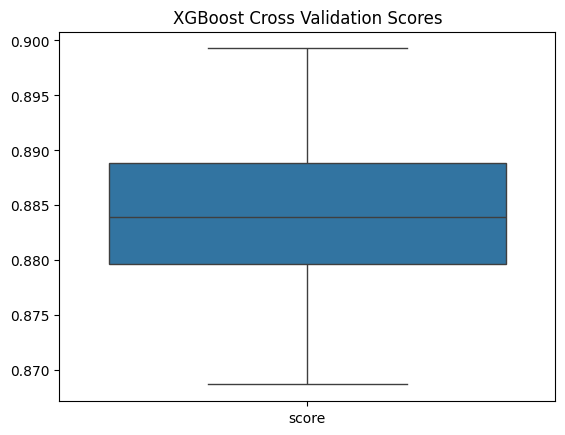

In [216]:
scores = cross_val_score(best_model,X_test, y_test,
                        cv=10, n_jobs=4,
                        params=dict(eval_set=[(X_val, y_val)]))

df_score = pd.DataFrame({'score':scores})
sns.boxplot(df_score)
plt.title('XGBoost Cross Validation Scores')
plt.show()

Que tasa de interes se deberia cobrar promedio para cubrir las perdidas esperadas?


In [267]:
# Tasa de interes promedio real
X_test.remainder__loan_int_rate.mean()

10.984237953438006

In [273]:
X_test.columns

Index(['cat_preprocess__loan_grade', 'cat_preprocess_2__loan_intent',
       'remainder__person_age', 'remainder__person_income',
       'remainder__person_emp_length', 'remainder__loan_amnt',
       'remainder__loan_int_rate', 'remainder__loan_percent_income',
       'remainder__cb_person_cred_hist_length'],
      dtype='object')

In [278]:
risk_primium = expected_loss_test/(X_test.remainder__loan_amnt.sum() - expected_loss_test)

In [285]:
(X_test.remainder__loan_amnt.sum() - expected_loss_test)*(1+risk_primium)

77834025.0

In [288]:
print('Tasa de interes promedio para cubrir la perdida esperada')
print(f'{risk_primium:.2f}')

Tasa de interes promedio para cubrir la perdida esperada
0.22


Cual es el capital minimo necesario para que la institucion absorba las perdidas nos esperadas

In [290]:
capital_minimio = sim_unexp_loss_test - expected_loss_test
print('El capital minimo que deberia tener la institucion es de: ')
print(f'{capital_minimio:,.2f}')

El capital minimo que deberia tener la institucion es de: 
344,502.19
